# Breast Cancer Detection 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import recall_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("breastCancer.csv")

In [3]:
data.head(5)

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


## Data pre-processing

In [4]:
data.shape

(699, 11)

In [5]:
data["class"].value_counts()

class
2    458
4    241
Name: count, dtype: int64

In [6]:
data.dtypes

id                    int64
clump_thickness       int64
size_uniformity       int64
shape_uniformity      int64
marginal_adhesion     int64
epithelial_size       int64
bare_nucleoli        object
bland_chromatin       int64
normal_nucleoli       int64
mitoses               int64
class                 int64
dtype: object

In [7]:
data[data["bare_nucleoli"] == "?"]

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
23,1057013,8,4,5,1,2,?,7,3,1,4
40,1096800,6,6,6,9,6,?,7,8,1,2
139,1183246,1,1,1,1,1,?,2,1,1,2
145,1184840,1,1,3,1,2,?,2,1,1,2
158,1193683,1,1,2,1,3,?,1,1,1,2
164,1197510,5,1,1,1,2,?,3,1,1,2
235,1241232,3,1,4,1,2,?,3,1,1,2
249,169356,3,1,1,1,2,?,3,1,1,2
275,432809,3,1,3,1,2,?,2,1,1,2
292,563649,8,8,8,1,2,?,6,10,1,4


In [8]:
df = data.replace("?", np.nan)

In [9]:
df["bare_nucleoli"].head(25)

0       1
1      10
2       2
3       4
4       1
5      10
6      10
7       1
8       1
9       1
10      1
11      1
12      3
13      3
14      9
15      1
16      1
17      1
18     10
19      1
20     10
21      7
22      1
23    NaN
24      1
Name: bare_nucleoli, dtype: object

In [10]:
df.isnull().sum()

id                    0
clump_thickness       0
size_uniformity       0
shape_uniformity      0
marginal_adhesion     0
epithelial_size       0
bare_nucleoli        16
bland_chromatin       0
normal_nucleoli       0
mitoses               0
class                 0
dtype: int64

In [11]:
df["bare_nucleoli"] = pd.to_numeric(df["bare_nucleoli"], errors='coerce')

In [12]:
df = df.fillna(df.median(numeric_only=True))

In [13]:
df["bare_nucleoli"] = df["bare_nucleoli"].astype("int64")
df.dtypes

id                   int64
clump_thickness      int64
size_uniformity      int64
shape_uniformity     int64
marginal_adhesion    int64
epithelial_size      int64
bare_nucleoli        int64
bland_chromatin      int64
normal_nucleoli      int64
mitoses              int64
class                int64
dtype: object

In [14]:
df.isnull().sum()

id                   0
clump_thickness      0
size_uniformity      0
shape_uniformity     0
marginal_adhesion    0
epithelial_size      0
bare_nucleoli        0
bland_chromatin      0
normal_nucleoli      0
mitoses              0
class                0
dtype: int64

## Exploratory Data Analysis

In [15]:
df.head()

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [16]:
df.drop("id", axis=1, inplace=True)

In [17]:
df.describe()

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.486409,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.621929,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [18]:
diagnosis_mapping = {2: 0, 4: 1}

df["class"] = df["class"].map(diagnosis_mapping)

## Data Visualization

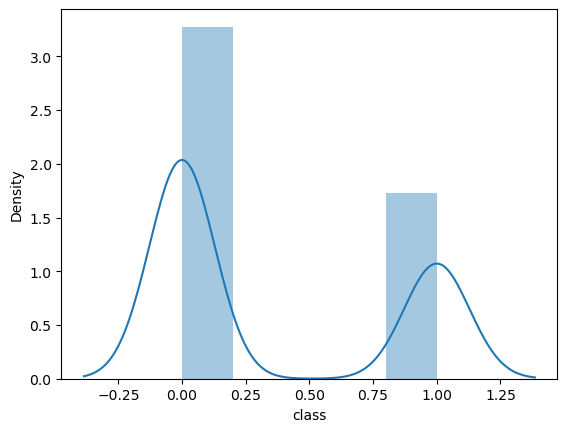

In [19]:
sns.distplot(df["class"])
plt.show()

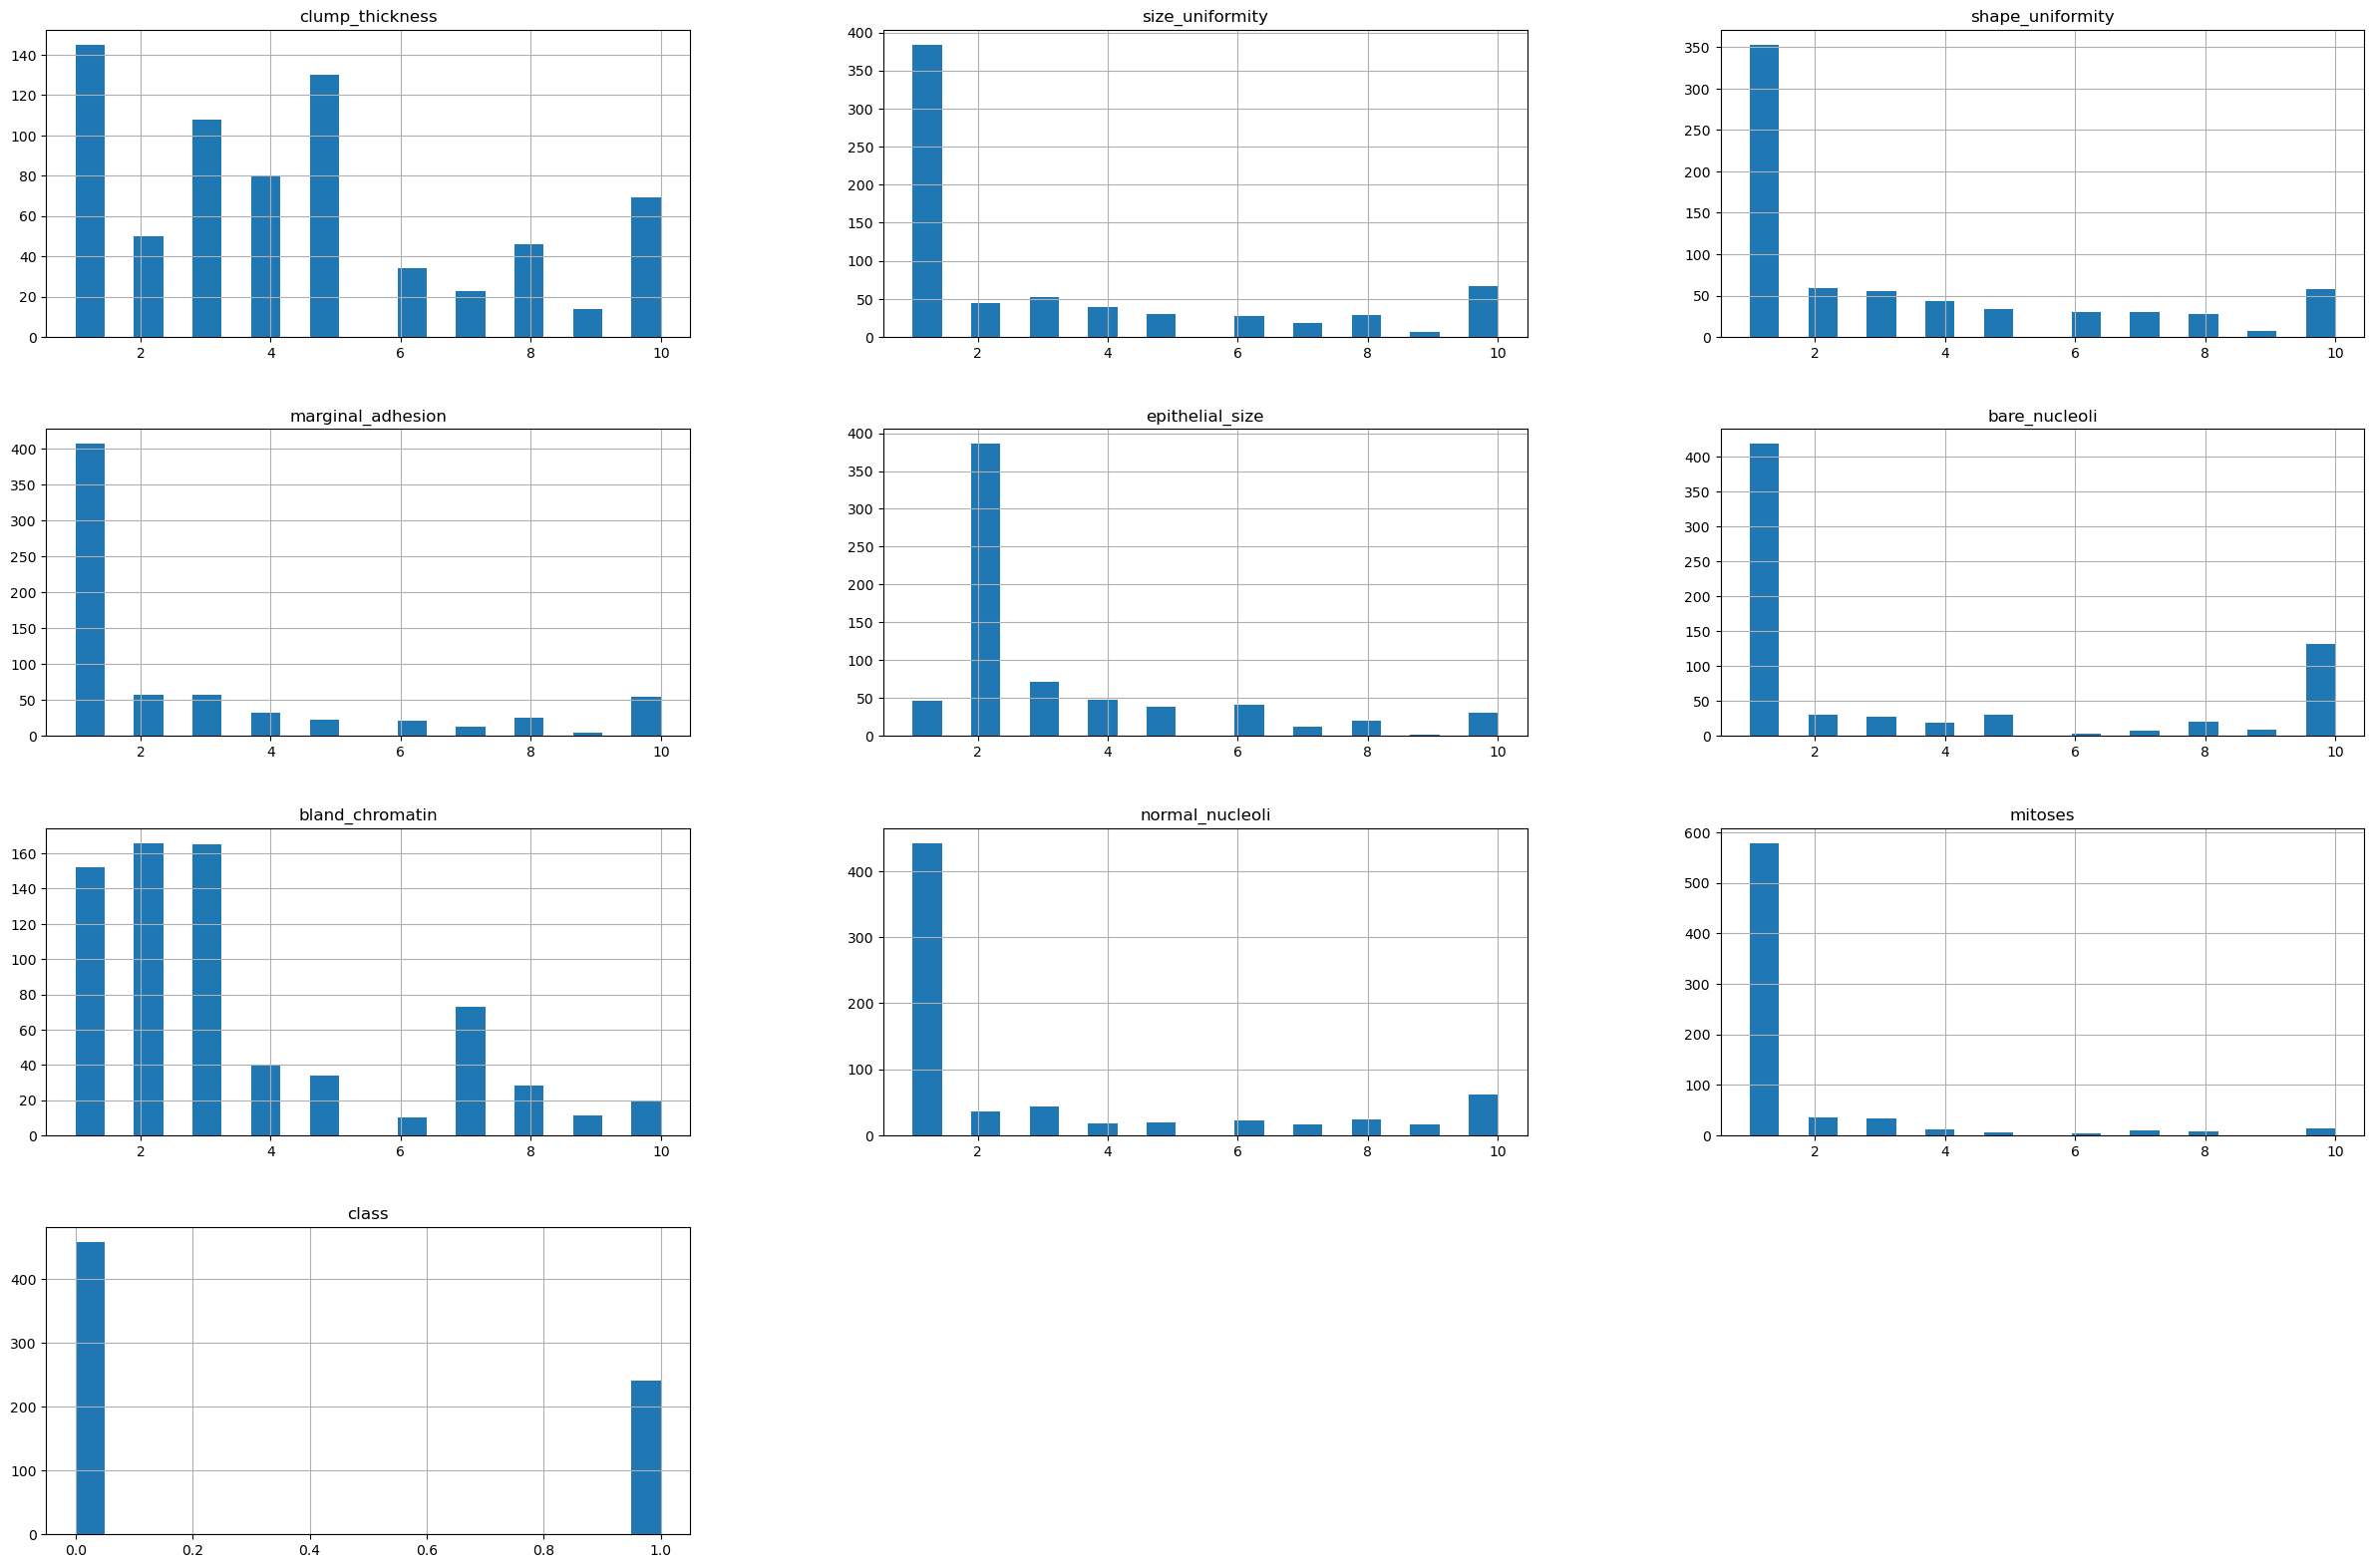

In [20]:
df.hist(bins=20, figsize=(30,30), layout=(6,3))
plt.show()

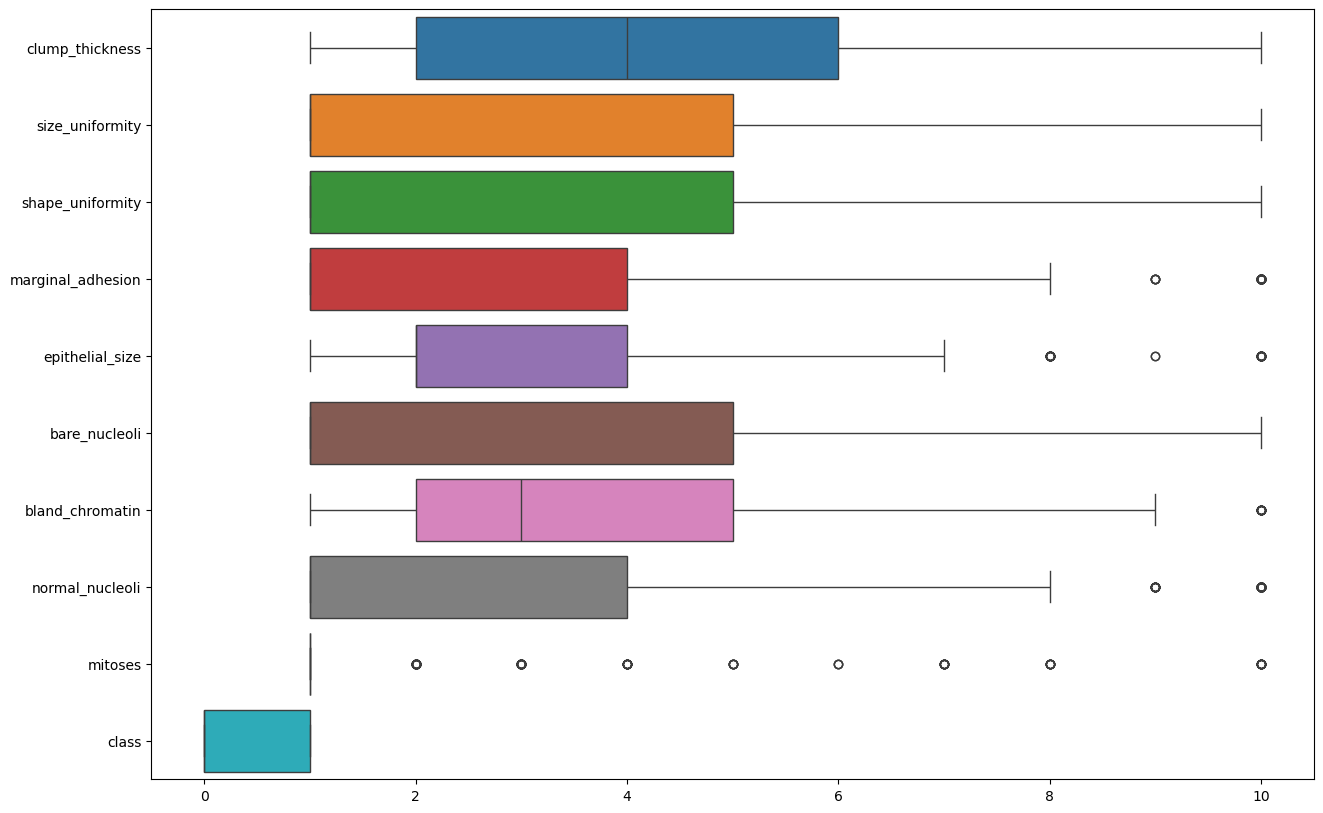

In [21]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df, orient="h")
plt.show()

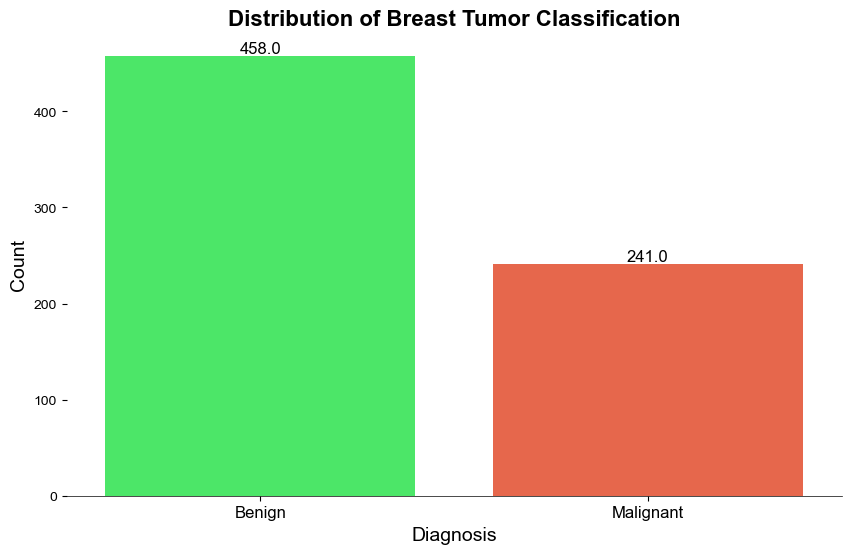

In [22]:
colors = ['#33FF57','#FF5733']

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='class', data=df, palette=colors)

plt.title('Distribution of Breast Tumor Classification', fontsize=16, fontweight='bold')
plt.xlabel('Diagnosis', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['Benign','Malignant'], fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

sns.set(style="whitegrid")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)

plt.show()

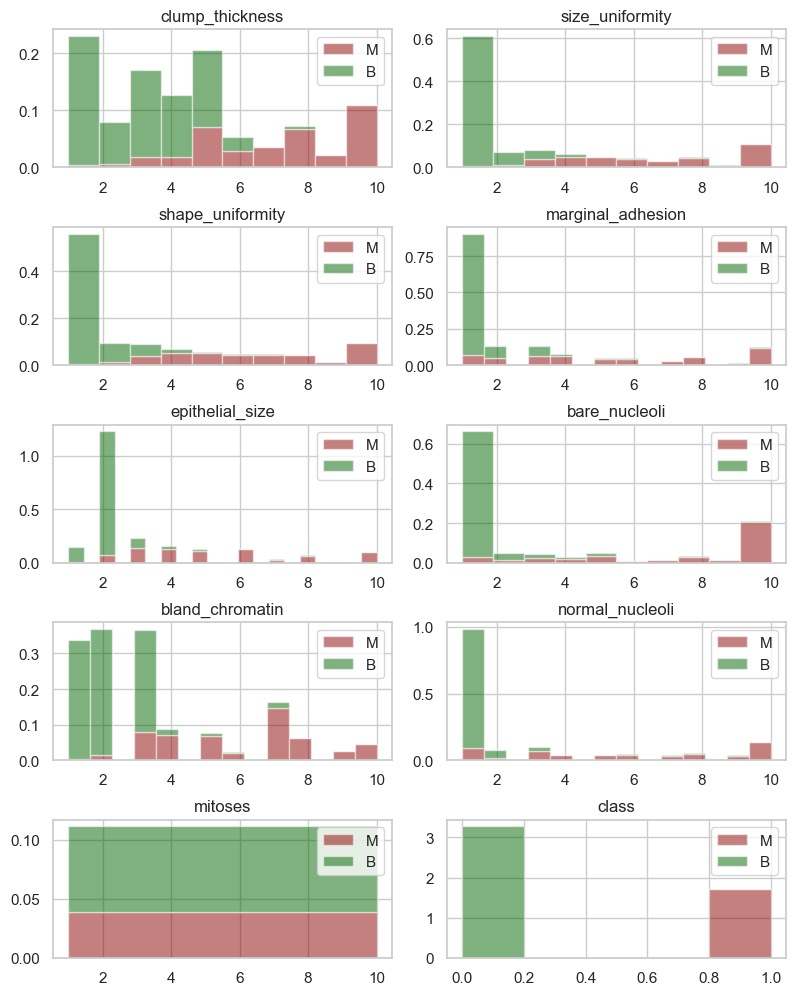

In [23]:
features_mean = list(df.columns[0:11])

dfM=df[df['class'] ==1]
dfB=df[df['class'] ==0]

plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))
axes = axes.ravel()

for idx, ax in enumerate(axes):
    feature = features_mean[idx]
    
    ax.hist([dfM[feature], dfB[feature]], bins="fd", alpha=0.5, stacked=True, density=True, label=['M', 'B'], color=['darkred', 'darkgreen'])
    ax.legend(loc='upper right')
    ax.set_title(feature)

plt.tight_layout()
plt.show()

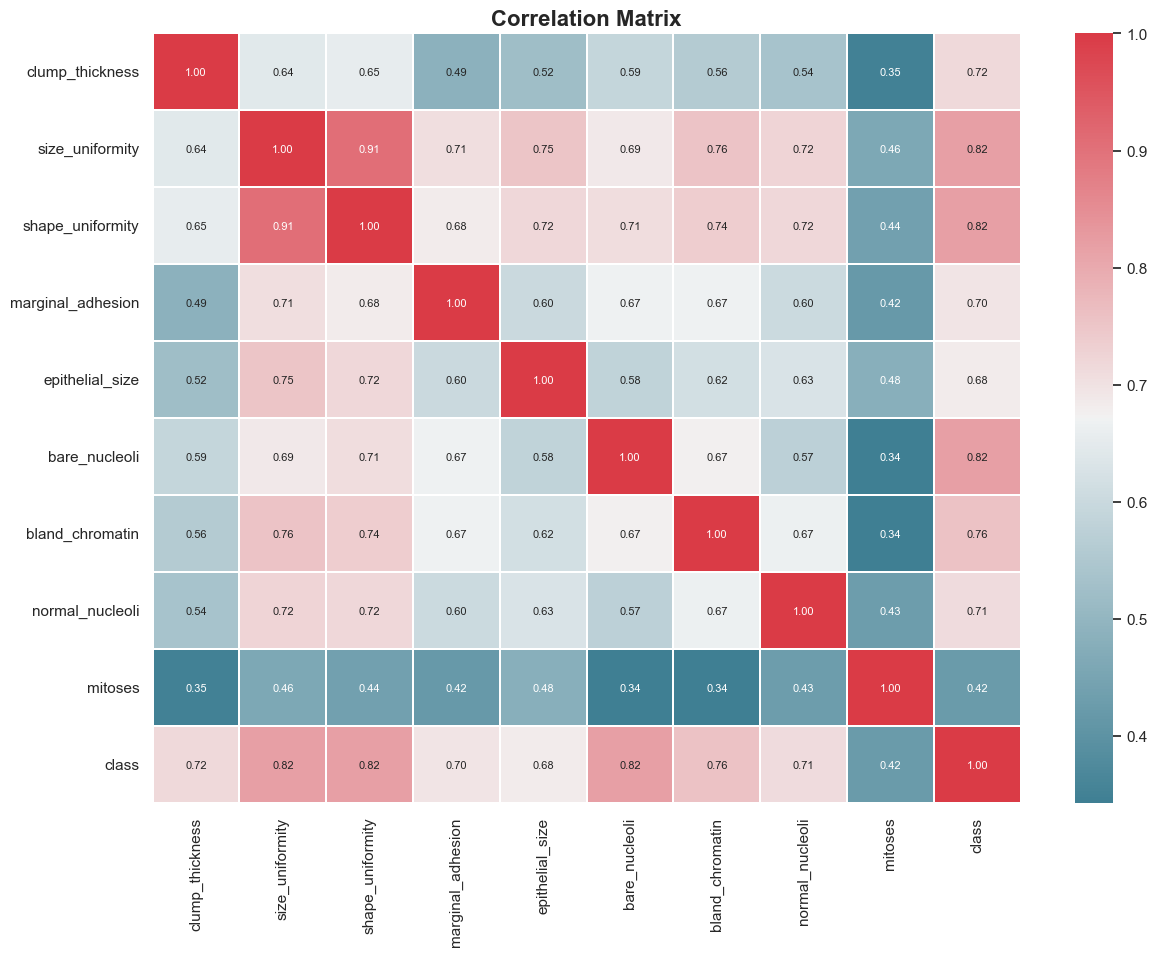

In [24]:
correlation_matrix = df.corr()

plt.figure(figsize=(14, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt=".2f",annot_kws={'size': 8}, linewidths=.1)

plt.title("Correlation Matrix", fontsize=16, fontweight='bold')
plt.show()

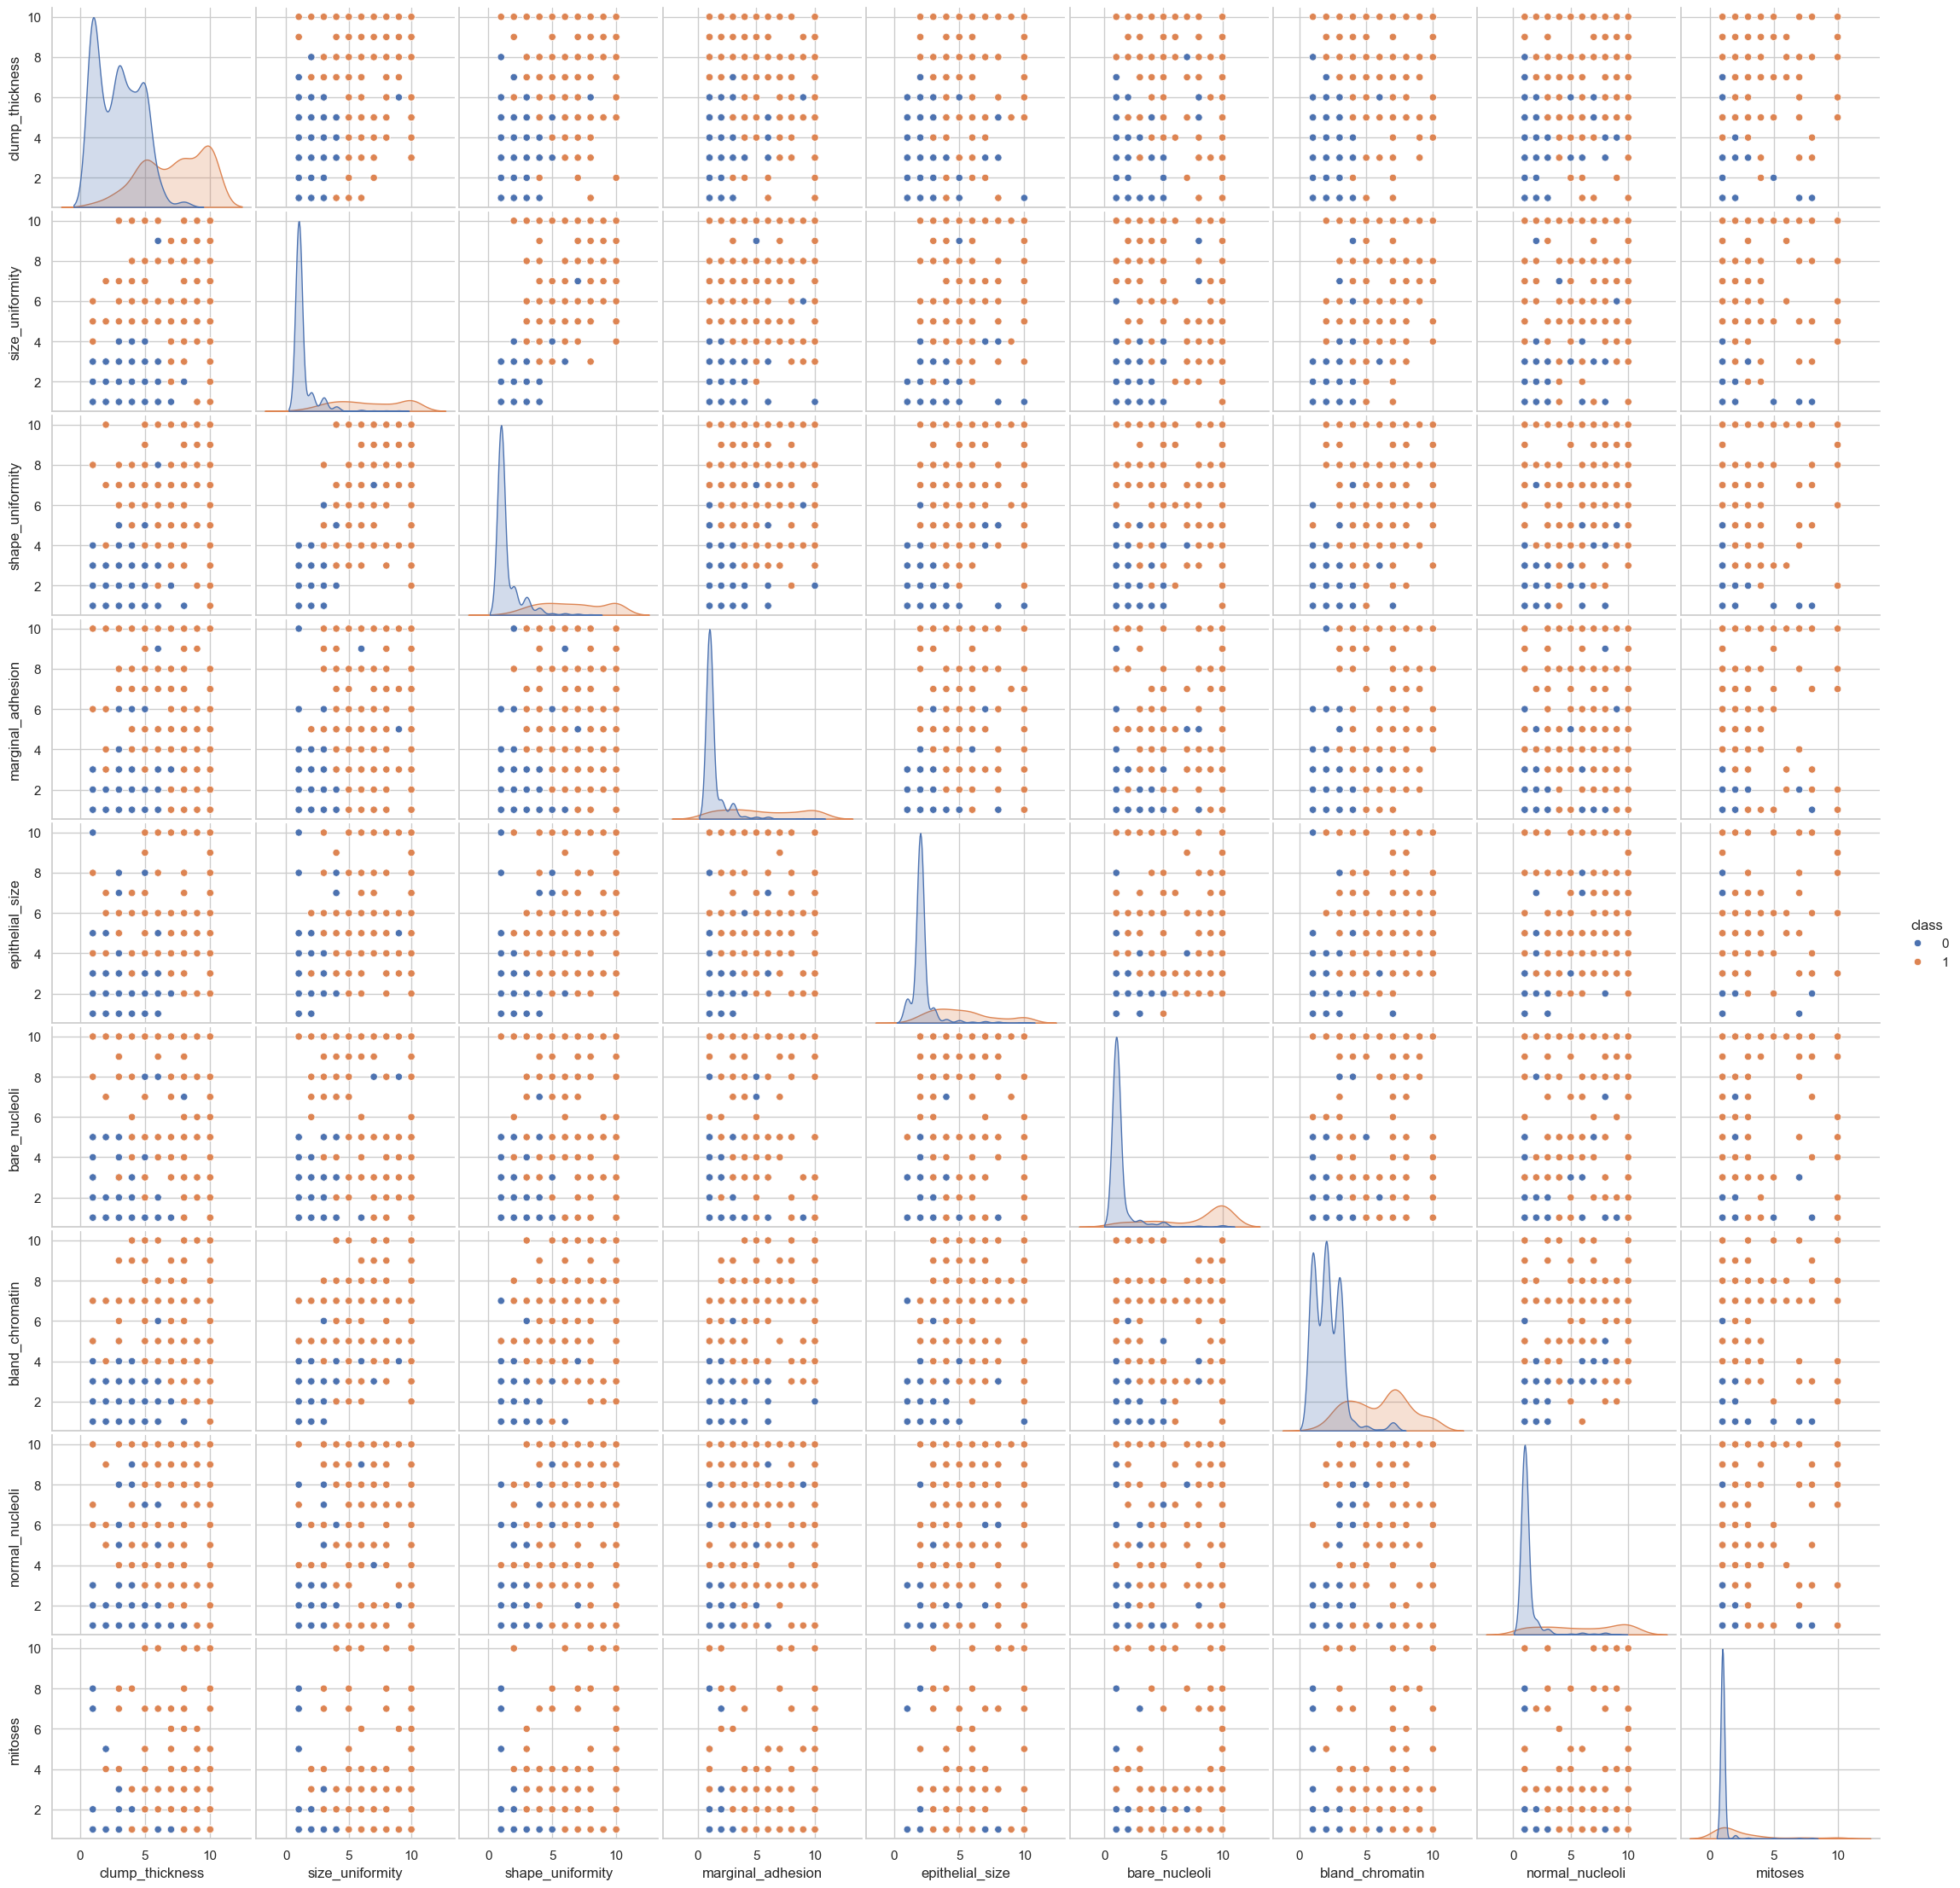

In [25]:
sns.pairplot(df, hue="class", diag_kind="kde")
plt.show()

## Building Our Models

In [26]:
y = df["class"]
X = df.drop("class",axis=1)

In [27]:
from scipy.stats import zscore
X = zscore(X)
X.head()

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses
0,0.206936,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-0.179662,-0.611825,-0.343912
1,0.206936,0.283845,0.266875,0.768621,1.710106,1.799664,-0.179662,-0.284112,-0.343912
2,-0.503866,-0.699995,-0.743299,-0.633247,-0.549561,-0.410685,-0.179662,-0.611825,-0.343912
3,0.562336,1.595632,1.613773,-0.633247,-0.097628,0.141902,-0.179662,1.354454,-0.343912
4,-0.148465,-0.699995,-0.743299,0.067687,-0.549561,-0.686979,-0.179662,-0.611825,-0.343912


In [28]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=0)

print("Shape of xTrain: ",xTrain.shape)
print("Shape of yTrain: ",yTrain.shape)
print("Shape of xTest: ",xTest.shape)
print("Shape of yTest: ",yTest.shape)

Shape of xTrain:  (559, 9)
Shape of yTrain:  (559,)
Shape of xTest:  (140, 9)
Shape of yTest:  (140,)


### KNN 

In [29]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

params = {"n_neighbors": [1,3,5,7,9,11]}

kFold = KFold(n_splits=10, shuffle=True, random_state=0)

gridSearchKNN = GridSearchCV(estimator=model, param_grid=params, cv=kFold, scoring="recall")

gridSearchKNN.fit(xTrain,yTrain)

print("En iyi parametreler: ", gridSearchKNN.best_params_)
print("En iyi Recall metrik: ", gridSearchKNN.best_score_)

bestModelKNN = gridSearchKNN.best_estimator_

yPred = bestModelKNN.predict(xTest)

scoreKNN = round(recall_score(yTest,yPred)*100,2)
print("Recall Score: ", scoreKNN)

En iyi parametreler:  {'n_neighbors': 3}
En iyi Recall metrik:  0.9487845487845489
Recall Score:  96.36


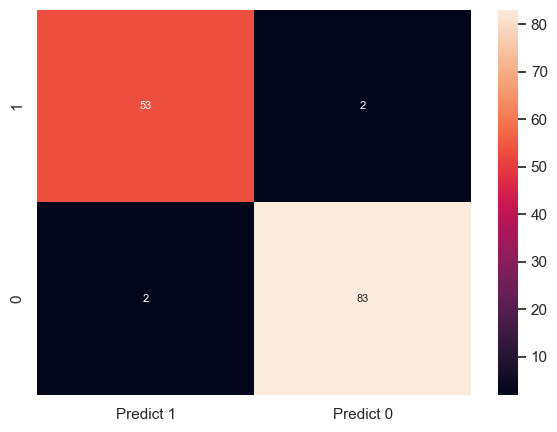

In [30]:
cm=confusion_matrix(yTest, yPred, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)
plt.show()

### Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

params = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["liblinear", "saga"]
}

gridSearchLR = GridSearchCV(estimator=model, param_grid=params, cv=kFold, scoring="recall")

gridSearchLR.fit(xTrain, yTrain)

print("En iyi parametreler: ", gridSearchLR.best_params_)
print("En iyi Recall metrik: ", gridSearchLR.best_score_)

bestModelLR = gridSearchLR.best_estimator_

yPred = bestModelLR.predict(xTest)

scoreLR = round(recall_score(yTest, yPred) * 100, 2)
print("Recall Score: ", scoreLR)

En iyi parametreler:  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
En iyi Recall metrik:  0.9646020646020645
Recall Score:  98.18


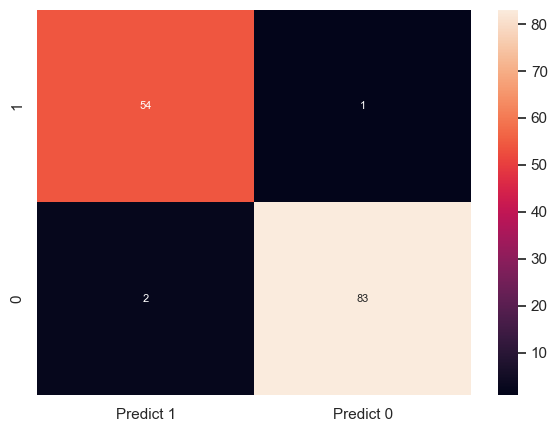

In [32]:
cm=confusion_matrix(yTest, yPred, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)
plt.show()

### Naive Bayes

In [33]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

params = {}

kFold = KFold(n_splits=10, shuffle=True, random_state=0)

gridSearchNB = GridSearchCV(estimator=model, param_grid=params, cv=kFold, scoring="recall")

gridSearchNB.fit(xTrain, yTrain)

print("En iyi parametreler: ", gridSearchNB.best_params_)
print("En iyi Recall metrik: ", gridSearchNB.best_score_)

bestModelNB = gridSearchNB.best_estimator_

yPred = bestModelNB.predict(xTest)

scoreNB = round(recall_score(yTest, yPred) * 100, 2)
print("Recall Score: ", scoreNB)

En iyi parametreler:  {}
En iyi Recall metrik:  0.9782384282384282
Recall Score:  98.18


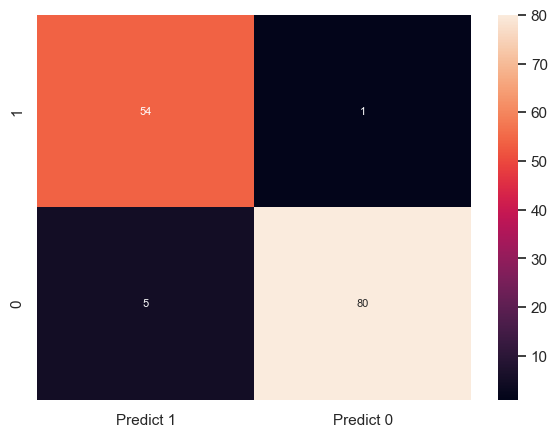

In [34]:
cm=confusion_matrix(yTest, yPred, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)
plt.show()

### SVM

In [35]:
from sklearn.svm import SVC

model = SVC()

params = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"]
}

gridSearchSVC = GridSearchCV(estimator=model, param_grid=params, cv=kFold, scoring="recall")

gridSearchSVC.fit(xTrain, yTrain)

print("En iyi parametreler: ", gridSearchSVC.best_params_)
print("En iyi Recall metrik: ", gridSearchSVC.best_score_)

bestModelSVC = gridSearchSVC.best_estimator_

yPred = bestModelSVC.predict(xTest)


scoreSVM = round(recall_score(yTest, yPred) * 100, 2)
print("Recall Score: ", scoreSVM)

En iyi parametreler:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
En iyi Recall metrik:  0.9691475191475192
Recall Score:  98.18


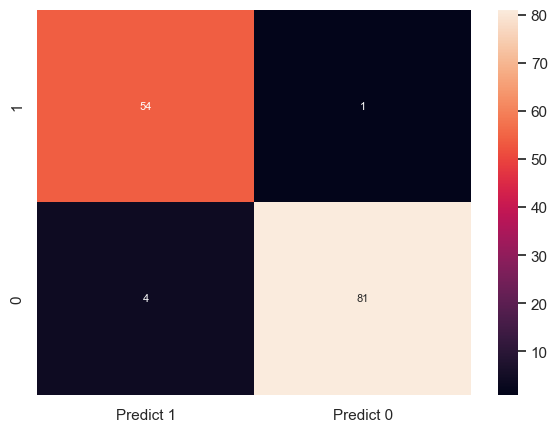

In [36]:
cm=confusion_matrix(yTest, yPred, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)
plt.show()

### Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

params = {
    "max_depth": [10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

gridSearchDT = GridSearchCV(estimator=model, param_grid=params, cv=kFold, scoring="recall")

gridSearchDT.fit(xTrain, yTrain)

print("En iyi parametreler: ", gridSearchDT.best_params_)
print("En iyi Recall metrik: ", gridSearchDT.best_score_)

bestModelDT = gridSearchDT.best_estimator_

yPred = bestModelDT.predict(xTest)

scoreDT = round(recall_score(yTest, yPred) * 100, 2)
print("Recall Score: ", scoreDT)

En iyi parametreler:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
En iyi Recall metrik:  0.8937131495955025
Recall Score:  92.73


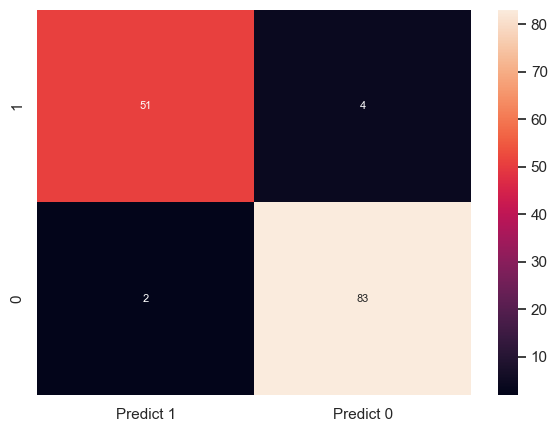

In [38]:
cm=confusion_matrix(yTest, yPred, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)
plt.show()

### Stacking

In [39]:
from sklearn.ensemble import StackingClassifier

knn = KNeighborsClassifier(n_neighbors=gridSearchKNN.best_params_['n_neighbors'])
lr = LogisticRegression(C=gridSearchLR.best_params_['C'], solver=gridSearchLR.best_params_['solver'])
nb = GaussianNB()
svm = SVC(C=gridSearchSVC.best_params_['C'], kernel=gridSearchSVC.best_params_['kernel'], gamma=gridSearchSVC.best_params_['gamma'])

lastModel = LogisticRegression()

stackingClassifier = StackingClassifier(
    estimators=[
        ('knn', knn),
        ('log_reg', lr),
        ('naive_bayes', nb),
        ('svm', svm)
    ],
    final_estimator=lastModel,
    cv=10
)

stackingClassifier.fit(xTrain, yTrain)

yPred = stackingClassifier.predict(xTest)

scoreStacking = round(recall_score(yTest, yPred) * 100, 2)
print("Recall Score: ", scoreStacking)

Recall Score:  98.18


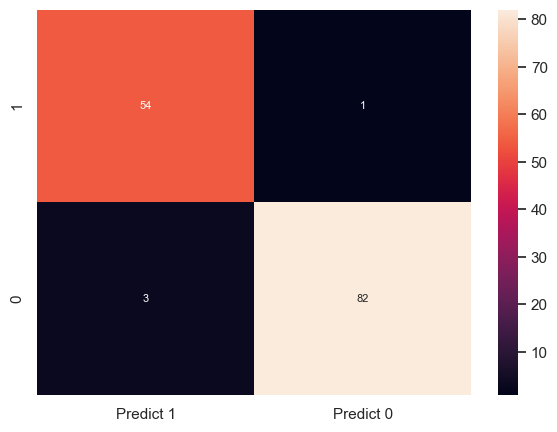

In [40]:
cm=confusion_matrix(yTest, yPred, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)
plt.show()

### Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

gridSearchRF = GridSearchCV(estimator=model, param_grid=params, cv=kFold, scoring="recall")

gridSearchRF.fit(xTrain, yTrain)

print("En iyi parametreler: ", gridSearchRF.best_params_)
print("En iyi Recall metrik: ", gridSearchRF.best_score_)

bestModelRF = gridSearchRF.best_estimator_
yPred = bestModelRF.predict(xTest)

scoreRF = round(recall_score(yTest, yPred) * 100, 2)
print("Recall Score: ", scoreRF)

En iyi parametreler:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
En iyi Recall metrik:  0.9739094239094239
Recall Score:  98.18


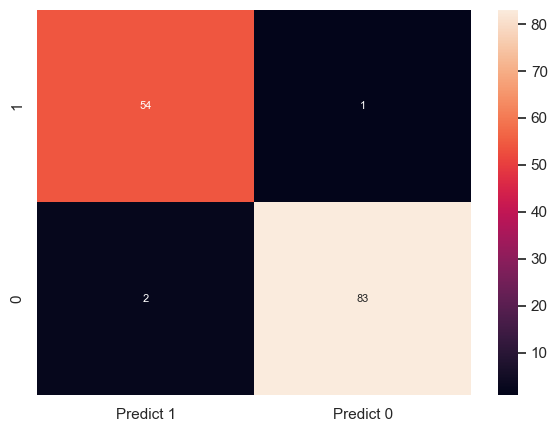

In [42]:
cm=confusion_matrix(yTest, yPred, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)
plt.show()

### XGBoost

In [43]:
import xgboost as xgb

model = xgb.XGBClassifier()

params = {
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.1, 0.3],
    "n_estimators": [100, 200, 300],
    "gamma": [0, 0.1, 0.3],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}


gridSearchXGB = GridSearchCV(estimator=model, param_grid=params, cv=kFold, scoring="recall")

gridSearchXGB.fit(xTrain, yTrain)

print("En iyi parametreler: ", gridSearchXGB.best_params_)
print("En iyi Recall metrik: ", gridSearchXGB.best_score_)

bestModelXGB = gridSearchXGB.best_estimator_
yPred = bestModelXGB.predict(xTest)

# Recall Score hesapla
scoreXGB = round(recall_score(yTest, yPred) * 100, 2)
print("Recall Score: ", scoreXGB)


En iyi parametreler:  {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}
En iyi Recall metrik:  0.9563529063529064
Recall Score:  98.18


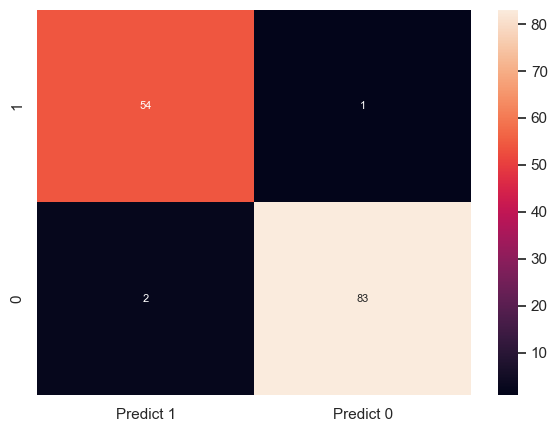

In [45]:
cm=confusion_matrix(yTest, yPred, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)
plt.show()

### MLP

In [47]:
from sklearn.neural_network import MLPClassifier

model_mlp = MLPClassifier()

params_mlp = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
    "activation": ["logistic", "tanh", "relu"],
    "solver": ["sgd", "adam"],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate": ["constant", "invscaling", "adaptive"]
}

gridSearchMLP = GridSearchCV(estimator=model_mlp, param_grid=params_mlp, cv=kFold, scoring="recall")

gridSearchMLP.fit(xTrain, yTrain)

print("En iyi parametreler: ", gridSearchMLP.best_params_)
print("En iyi Recall metrik: ", gridSearchMLP.best_score_)

bestModelMLP = gridSearchMLP.best_estimator_
yPred = bestModelMLP.predict(xTest)

scoreMLP = round(recall_score(yTest, yPred) * 100, 2)
print("Recall Score: ", scoreMLP)


En iyi parametreler:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'solver': 'adam'}
En iyi Recall metrik:  0.970979020979021
Recall Score:  98.18


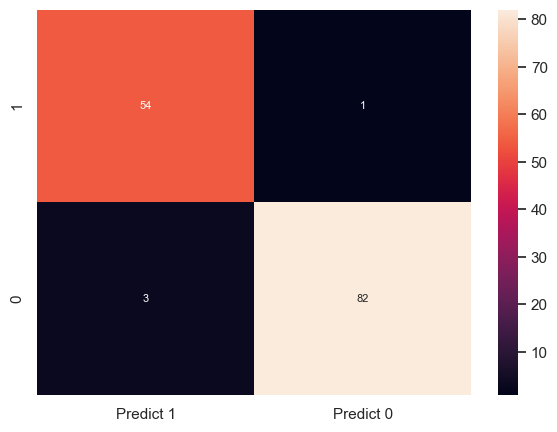

In [48]:
cm=confusion_matrix(yTest, yPred, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)
plt.show()

## Comparison

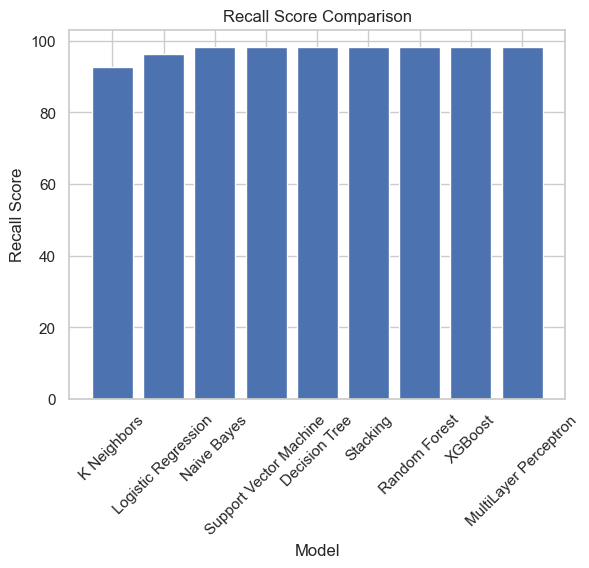

In [50]:
RecallScores = np.sort([scoreKNN, scoreLR, scoreNB, scoreSVM, scoreDT, scoreStacking, scoreRF, scoreXGB, scoreMLP])

plt.bar(["K Neighbors", "Logistic Regression", "Naive Bayes", "Support Vector Machine",  "Decision Tree", "Stacking", "Random Forest", "XGBoost", "MultiLayer Perceptron"], RecallScores)
plt.title("Recall Score Comparison")
plt.xlabel("Model")
plt.ylabel("Recall Score")
plt.xticks(rotation=45)
plt.show()